In [21]:
import numpy as np
import matplotlib.pyplot as plt

# PHYS 541 Final Project: The Cracker Barrel Peg Game
## Name: Jacob Buchanan

If you've ever been to a Cracker Barrel, you've probably made an attempt at the peg game. It's pretty straightforward. You have a triangle with some pegs and one open space to start. You have to jump all the pegs and get as few as you can at the end. It's difficult to get a good solution (I always end up doing worse the more I try). I'd like to study this game a bit by writing a simulation of it.

The triangle nature of this game makes simulating it somewhat tricky. I'll use a matrix and some defined Python classes to run this.

First I'll define a "space" class. It can hold a peg object and keeps track of activity.

In [22]:
class Space:
    def __init__(self, peg=None):
        self.peg = peg
    
    def set_peg(self, peg):
        self.peg = peg
        
    def remove_peg(self):
        peg = self.peg
        self.peg = None
        return peg

    def has_peg(self):
        if self.peg is not None:
            return True
        else:
            return False

I'll now define a peg. It knows how many moves it has made and if it's still in the game.

In [23]:
class Peg:
    def __init__(self, x, y):
        self.num_moves = 0
        self.in_game = True
        self.x = x
        self.y = y
        
    def move(self, to_x, to_y):
        self.x = to_x
        self.y = to_y
        self.num_moves += 1
    
    def remove(self):
        self.in_game = False

In [24]:
class Move:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    
    def __str__(self):
        return f"Move peg at {self.p1} to {self.p2} which jumps over {self.jump_coord()}"
    
    def jump_coord(self):
        """
        gets the coordinate that the move jumps over
        :return: (x,y)
        """
        diff_x = self.p2[0] - self.p1[0]
        if diff_x > 0:
            jumped_x = self.p2[0] - 1
        elif diff_x < 0:
            jumped_x = self.p2[0] + 1
        else:
            jumped_x = self.p2[0]
        diff_y = self.p2[1] - self.p1[1]
        if diff_y > 0:
            jumped_y = self.p2[1] - 1
        elif diff_y < 0:
            jumped_y = self.p2[1] + 1
        else:
            jumped_y = self.p2[1]
        return jumped_x, jumped_y

Now I'll define the board. This is effectively a matrix with 5 rows and n columns (where n is the row number).

In [25]:
class Board:
    def __init__(self, empty_x=0, empty_y=0):
        self.board = [
            [Space()],
            [Space(), Space()],
            [Space(), Space(), Space()],
            [Space(), Space(), Space(), Space()],
            [Space(), Space(), Space(), Space(), Space()],
        ]
        self.setup_board((empty_x,empty_y))
        self.current_moves = []
        self.move_history = []

    def setup_board(self, empty_pos=(0,0)):
        empty_space = False
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if not (i,j) == empty_pos:
                    self.board[i][j].set_peg(Peg(i,j))
                else:
                    empty_space = True
        if not empty_space:
            raise ValueError("One empty space required")
        
    def check_space(self, p):
        if p in self:
            return self.board[p[0]][p[1]]
        else:
            return None
        
    def check_move(self, move):
        """
        Checks a move from p1 to p2 (assuming the jump spacing is valid)
        :param p1: tuple (x,y)
        :param p2: tuple (x,y)
        :return: Boolean
        """
        if (move.p1 in self) and (move.p2 in self):
            if self.check_space(move.p1).has_peg():
                if not self.check_space(move.p2).has_peg():
                    if self.check_space(move.jump_coord()).has_peg():
                        return True
        return False
        
    def get_moves(self):
        moves = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j].has_peg():
                    # It has a peg, can it move?
                    for dx in (-2, 0, 2):
                        for dy in (-2, 0, 2):
                            move = Move((i,j),(i+dx,j+dy))
                            if (dx, dy) == (0, 0):
                                continue
                            elif (i+dx < 0) or (j+dy < 0):
                                continue
                            elif dx*dy < 0:
                                # Avoid case where the peg jumps too far
                                continue
                            elif not self.check_move(move):
                                continue
                            else:
                                moves.append(move)
        self.current_moves = moves
        return moves
    
    def execute_move(self, move):
        if self.check_move(move):
            # Remove peg at jump coord
            jump_coord = move.jump_coord()
            self.check_space(jump_coord).remove_peg()
            # Move peg
            peg = self.check_space(move.p1).remove_peg()
            self.check_space(move.p2).set_peg(peg)
            self.move_history.append(move)
            
    def num_pegs(self):
        n = 0
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.check_space((i,j)).has_peg():
                    n += 1
        return n
                
    def __str__(self):
        output = ""
        for row in self.board:
            for space in row:
                if space.has_peg():
                    output += "1 "
                else:
                    output += "0 "
            output += "\n"
        return output
    
    def __contains__(self, item):
        """
        Check if coordinate is within the bounds of the board
        :param item: A tuple (x,y)
        :return: True or False
        """
        try:
            p = self.board[item[0]][item[1]]
            return True
        except IndexError:
            return False

Ok, now I'll try to run a simulation with this stuff. Here's a function to run the game with uniform probabilities for each possible move. 

In [26]:
def run_game(x0, y0):
    """
    Run the game with the initial space at p0 = (x0,y0)
    :param x0: x coordinate of empty space
    :param y0: y coordinate of empty space
    :return: (board object, number of moves)
    """
    n_moves = 0
    board = Board(x0, y0)
    moves = board.get_moves()
    while len(moves) != 0:
        prob = 1 / len(moves)
        prob_array = np.zeros(len(moves))
        prob_array += prob
        move_choice = np.random.choice(moves, p=prob_array)
        board.execute_move(move_choice)
        n_moves += 1
        moves = board.get_moves()
    return board, n_moves

Let's run this 1000 times and see what happens

Text(0, 0.5, 'Count')

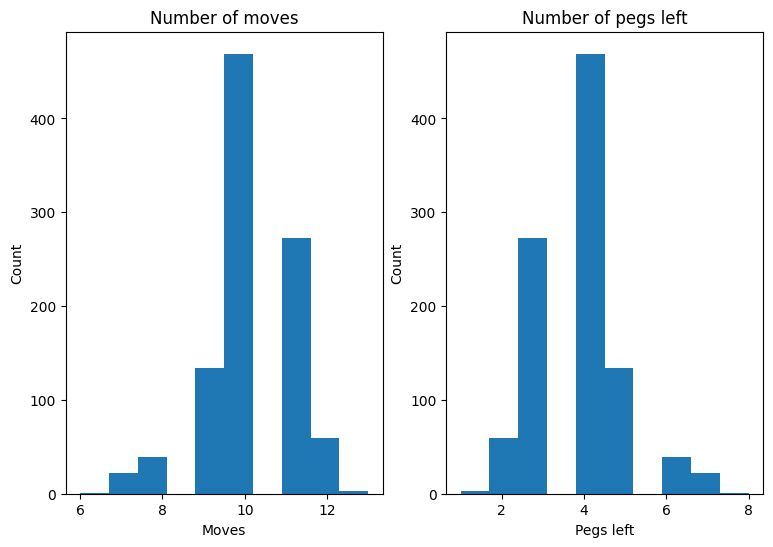

In [27]:
n_sims = 1000
moves = []
pegs = []
for i in range(n_sims):
    game = run_game(0,0)
    moves.append(game[1])
    pegs.append(game[0].num_pegs())

fig, ax = plt.subplots(1, 2, figsize=(9,6))
ax[0].hist(moves)
ax[0].set_title("Number of moves")
ax[0].set_xlabel("Moves")
ax[0].set_ylabel("Count")
ax[1].hist(pegs)
ax[1].set_title("Number of pegs left")
ax[1].set_xlabel("Pegs left")
ax[1].set_ylabel("Count")

In [28]:
def run_many_games(x0, y0, n_sims):
    """
    Runs the game at (x0,y0) starting space n_sims times.
    Returns the average number of pegs left
    :param x0: 
    :param y0: 
    :param n_sims: 
    :return: 
    """
    moves = []
    pegs = []
    for i in range(n_sims):
        game = run_game(0,0)
        moves.append(game[1])
        pegs.append(game[0].num_pegs())
    return np.average(pegs)

Now let's do that for each starting space. We'll see which space has the best odds of getting a good result.

In [29]:
pegs = {}
for x in range(5):
    for y in range(5):
        if x >= y:
            # Valid space
            pegs[(x,y)] = run_many_games(x,y,n_sims)

print(pegs)

{(0, 0): 3.92, (1, 0): 3.854, (1, 1): 3.954, (2, 0): 3.932, (2, 1): 3.938, (2, 2): 3.909, (3, 0): 3.884, (3, 1): 3.858, (3, 2): 3.95, (3, 3): 3.906, (4, 0): 3.914, (4, 1): 3.882, (4, 2): 3.913, (4, 3): 3.876, (4, 4): 3.886}
